In [1]:
#This is for Know the satellites position with a specific time and date 

In [2]:
#Now I need to know the near 
import os, sys, time, datetime, re, gpstk
from ftplib import FTP
import pandas as pd
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import math
import geocoder #to get the elevation in a lon-lat point



%matplotlib inline
#%run -i code/utils.py

In [3]:
class WGS84:
    """General parameters defined by the WGS84 system"""
    #Semimajor axis length (m)
    a = 6378137.0
    #Semiminor axis length (m)
    b = 6356752.3142
    #Ellipsoid flatness (unitless)
    f = (a - b) / a
    #Eccentricity (unitless)
    e = math.sqrt(f * (2 - f))
    #Speed of light (m/s)
    c = 299792458.
    #Relativistic constant
    F = -4.442807633e-10
    #Earth's universal gravitational constant
    mu = 3.986005e14
    #Earth rotation rate (rad/s)
    omega_ie = 7.2921151467e-5
    secsInWeek = 604800 
    secsInDay = 86400 
    gpsEpoch = (1980, 1, 6, 0, 0, 0)  # (year, month, day, hh, mm, ss)

In [4]:
def deg2rad(deg):
    """Converts degrees to radians"""
    return deg * math.pi / 180

def rad2deg(rad):
    """Converts radians to degrees"""
    return rad * 180 / math.pi

In [91]:
from datetime import datetime, timedelta
def UTC2GPS(fecha):
    '''
    @UTC2GPS: Método estático para convertir un objeto de la clase datetime a tiempo GPS
    @fecha datetime: Objeto de la clase datetime con la fecha a transformar en tiempo GPS.
    '''
    ## Obtenemos el número del día
    ## En python el día 0 es el lunes
    day = fecha.weekday()
    ## Si el día es Domingo (número 6) -> día = -1
    if day == 6 : day = -1
    ## Calculamos el tiempo GPS
    return ( (day + 1) * 86400 ) + int(fecha.strftime('%H')) * 3600 + int(fecha.strftime('%M')) * 60 + int(fecha.strftime('%S'))

def leap(date):
    """
    Return the number of leap seconds since 6/Jan/1980
    :param date: datetime instance
    :return: leap seconds for the date (int)
    """
    if date < datetime(1981, 6, 30, 23, 59, 59):
        return 0
    leap_list = [(1981, 6, 30), (1982, 6, 30), (1983, 6, 30),
                 (1985, 6, 30), (1987, 12, 31), (1989, 12, 31),
                 (1990, 12, 31), (1992, 6, 30), (1993, 6, 30),
                 (1994, 6, 30), (1995, 12, 31), (1997, 6, 30),
                 (1998, 12, 31), (2005, 12, 31), (2008, 12, 31),
                 (2012, 6, 30), (2015, 6, 30)]
    leap_dates = map(lambda x: datetime(x[0], x[1], x[2], 23, 59, 59), leap_list)
    for j in xrange(len(leap_dates[:-1])):
        if leap_dates[j] < date < leap_dates[j + 1]:
            return j + 1
    return len(leap_dates)
def GPS2UTC(week, secs):
    """
    :param week: GPS week number, i.e. 1866
    :param secs: number of seconds since the beginning of `week`
    :return: datetime instance with UTC time
    """
    import datetime
    secs_in_week = 604800
    gps_epoch = datetime.datetime(1980, 1, 6, 0, 0, 0)
    date_before_leaps = gps_epoch + datetime.timedelta(seconds=week * secs_in_week + secs)
    return date_before_leaps - datetime.timedelta(seconds=leap(date_before_leaps))

In [76]:
def to_radians(array):
    rads = array*(np.pi /180.)
    return rads

def compute_distance(df,longitude, latitude):
    R = 6371e3 # earth radius metres, mean radius = 6371km
    n = len(df.Latitude)
    ArrayLat = pd.Series([latitude] * n)
    ArrayLon = pd.Series([longitude] * n)
    #print len(ArrayLat), type(ArrayLat), type(df.Latitude)
    phi1 = to_radians(df.Latitude) #degrees to radians
    phi2 = to_radians(ArrayLat)
    lambda1 = to_radians(df.Longitude)
    lambda2 = to_radians(ArrayLon)
    dphi = phi2 - phi1
    dlambda = lambda2 - lambda1
    a = np.sin(dphi/2.)**2 + (np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2.)**2 )
    c = 2 * np.arctan2(np.sqrt(a),np.sqrt(1.-a))
    d = R * c
    return d

float_formatter = lambda x: "%.2f" % x

def to_skyplot(elevation, azimut):
    e = np.array(elevation)
    a = np.array(azimut)
    sx = ((90-e)/90) * np.sin (a * (np.pi/180))
    sy = ((90-e)/90) * np.cos (a * (np.pi/180))
    return (sx,sy)

In [77]:
#Thanks to https://github.com/twillis449
def gunzip_some_file(compressed_file,
                     uncompressed_file,
                     delete_file = 1):
    print 'uncompressing file 1 to file 2 ', compressed_file, uncompressed_file
# if file is already uncompressed, do nothing
    if compressed_file == uncompressed_file:
        return
    # make sure there is a file
    if not os.path.isfile(compressed_file):
        if(compressed_file[-1] == 'Z'):
            # try another form
            warnings.warn("No .Z form of compressed file '%s', trying .gz"%compressed_file)
            print "No .Z form of compressed file  trying .gz"
            new_compressed = compressed_file[:-1] + "gz"
            return gunzip_some_file(new_compressed, uncompressed_file,
                                    delete_file)
        raise Albus_RINEX.RINEX_Data_Barf("No such file '%s' to uncompress"%compressed_file)
    if compressed_file[-3:] != 'zip' and compressed_file[-1] != 'Z':
        # file is most likely uncompressed ...
        command = "mv  %s %s"%(compressed_file, uncompressed_file)
    elif (compressed_file[-3:] == 'zip'): # we have a trignet file
        command = "unzip -np %s '*d' > %s"%(compressed_file,uncompressed_file)
    else:   
        command = "gunzip -dc %s > %s"%(compressed_file,uncompressed_file)
    print 'gunzip executing ', command
    retcode = os.system(command)
    print 'gunzip returned ', retcode
# handle non-zero return code error from extraction 
    if(retcode):
        raise No_RINEX_File_Error("Could not run '%s'"%command)
    if(delete_file):
        try:
            os.remove(compressed_file)
        except:
            print 'failure to remove compressed file - probably not a compressed file'
    return


In [95]:
Sat_Time = "21:20:23"
Sat_Date = "13/03/2017"
Longitude_inGround = -73.1224429 
Latitude_inGround = 7.1388027


In [96]:
#Parse String to Date
import datetime

time_sat = datetime.datetime.strptime(Sat_Time,'%H:%M:%S')
date_sat = datetime.datetime.strptime(Sat_Date,'%d/%m/%Y')

InputDate = datetime.datetime.combine(datetime.date(date_sat.year, date_sat.month, date_sat.day), datetime.time(time_sat.hour, time_sat.minute,time_sat.second))
print InputDate

2017-03-13 21:20:23


In [97]:
day_of_year = InputDate.timetuple().tm_yday
day_of_year

72

In [108]:
UNAVCO_list = pd.read_csv("UNAVCOlist.csv")
UNAVCO_list.columns

Index([u'Unnamed: 0', u'CODE', u'Longitude', u'Latitude'], dtype='object')

search the nearest station

In [109]:
#Universidad Industrial de Santander
Latitude_inGround,Longitude_inGround

(7.1388027, -73.1224429)

In [116]:
d = compute_distance(UNAVCO_list,Longitude_inGround,Latitude_inGround)
UNAVCO_list['Distance'] = d

In [117]:
UNAVCO_list.sort_values(['Distance'], ascending=[True], inplace=True)
UNAVCO_list

,Unnamed: 0,CODE,Longitude,Latitude,Distance
3080,3080,SINC,-75.283500,9.336300,340965.850479
3007,3007,MONT,-75.680800,8.895200,342766.519589
2710,2710,MONT,-75.680800,8.895200,342766.519589
2644,2644,MONT,-75.680800,8.895200,342766.519589
2737,2737,VILL,-73.380100,4.065600,342911.761312
3107,3107,VILL,-73.380100,4.065600,342911.761312
2655,2655,VILL,-73.380100,4.065600,342911.761312
3018,3018,NEIR,-75.520200,5.171300,343691.722430
3042,3042,PIRA,-75.283300,4.916100,343763.611111
3069,3069,RUBI,-75.313200,4.937700,344355.308980


In [118]:
#search the nearest land stage
IDmin = UNAVCO_list.Distance.argmin()
S_Code = UNAVCO_list.CODE[IDmin]
S_Dist = UNAVCO_list.Distance[IDmin]
print S_Code,UNAVCO_list.Longitude[IDmin],UNAVCO_list.Latitude[IDmin],S_Dist

SINC -75.2835 9.3363 340965.850479


Now I have the Name of the Lan Station that I need.


In [119]:
UNAVCO_FTP = 'data-out.unavco.org'
NASA_FTP = 'cddis.gsfc.nasa.gov'

try:
    f = FTP(NASA_FTP)
    #f = FTP(UNAVCO_FTP)
    print f
    
except:
    pass
#print "Welcome:", f.getwelcome()
f.login()

#Now I wnat to look the folder that I need.
UNAVCO_FTP_path = '/pub/rinex/nav/' + str(InputDate.year) + '/' + str(day_of_year).zfill(3)
FTP_path ='/pub/gps/data/daily/'+ str(InputDate.year) + '/' + str(day_of_year).zfill(3) + '/' + str(InputDate.year)[2:] + 'n'

#[data-out.unavco.org] --> /pub/rinex/nav/2017/002
#[cddis.gsfc.nasa.gov] --> /pub/gps/data/daily/2017/001/17n --> 
#    FTP_path ='/pub/gps/data/daily/'+ str_year + '/' + str(day_of_year).zfill(3) + '/' + str_year[2:] + 'n'

print "Folder Needed:", f.cwd(FTP_path)
print "Current working directory:", f.pwd()

<ftplib.FTP instance at 0xa7562dec>
Folder Needed: 250 Directory successfully changed.
Current working directory: /pub/gps/data/daily/2017/072/17n


In [120]:
import os, sys
from ftplib import FTP 


LineData = 0
while (1):
    try:
        if(LineData>70):
            break
        IDmin = UNAVCO_list.Distance.argmin()
        NameStation = UNAVCO_list.CODE[IDmin]
        LineData += 1
        NameFile = NameStation.lower() + str(day_of_year).zfill(3) + '0.' + str(InputDate.year)[2:] + 'n.Z' 
        #For Now just GPS constallartion, I mean, .n file.'
        clear_output(wait=True)
        print("Try with station: %s" % (NameFile),"to " + str(float_formatter(UNAVCO_list.Distance[IDmin]/1000)) + " [Km]")
        print
        
        f.voidcmd("TYPE I")
        datasock, size = f.ntransfercmd("RETR "+ NameFile)
        bytes_so_far = 0
        fd = open(NameFile, 'wb')
        
        while 1:
            buf = datasock.recv(2048) 
            
            fd.write(buf)
            bytes_so_far += len(buf)
            clear_output(wait=True)
            print "Received",bytes_so_far, "of %d total bytes (%.1f%%)" % (size, 100 * bytes_so_far / float(size)),"bytes"
            sys.stdout.flush()
            if not buf:
                break
                 
            #if bytes_so_far == len(buf):
                #print 
                #break
        print("File %s" % (NameFile),"to " + str(float_formatter(UNAVCO_list.Distance[IDmin]/1000)) + " [Km]")
        fd.close()
        datasock.close()
        f.voidresp
        f.close()
        break
    except:
        UNAVCO_list = UNAVCO_list[UNAVCO_list.CODE != NameStation]

('Try with station: rold0720.17n.Z', 'to 452.34 [Km]')



In [105]:
NameFile

'coro0720.17n.Z'

In [106]:
gunzip_some_file(NameFile,'navRINEX',0)

uncompressing file 1 to file 2  coro0720.17n.Z navRINEX


NameError: global name 'warnings' is not defined

In [ ]:
#!head -29 $navRINEX

In [115]:
seconds = UTC2GPS(datetime.datetime.now())
seconds

136550

In [93]:
GPS2UTC(1937,seconds)

datetime.datetime(2017, 2, 20, 13, 31, 22)

In [17]:
def MeanToEccentricAnomaly(e,M):
    pi = math.pi
    if (e >= 1.0):
        print("MeanToEccenAnomaly does not support parabolic or hyperbolic orbits!")
    # Make sure M lies between -pi and pi
    M = math.fmod(M, 2*pi);
    if (M < pi):
        M = M + 2*pi
    elif (M > pi):
        M = M - 2*pi

    if ((M > -pi and M < 0) or (M > pi)):
        E = M - e
    else:
        E = M + e

    Enew = E
    zero = 1E-6;
    first = 1;
    while (first or abs(Enew - E) > zero):
        first = 0
        E = Enew
        Enew = E + (M - E + e*math.sin(E))/(1 - e*math.cos(E))

    E = Enew;
    return E

In [18]:
def TrueAnomaly(ec,E):
    '''
    ec = eccentricty  -  E = Eccentricity Anomaly
    '''
    return  math.atan( ( math.sqrt(1-ec**2)*math.sin(E) )/(math.cos(E) - ec  )  )

In [19]:
def GetPositionECEF(rj,fj):
    '''
    Position in Orbital Plane
    rj: Radial Distance - fj: True Anomaly
    http://web.ics.purdue.edu/~ecalais/teaching/geodesy/EAS_591T_2003_lab_4.htm
    '''
    x = rj * math.cos(fj)
    y = rj * math.sin(fj)
    return x,y

In [20]:
def GetPositionOrbitPlane(a,E,e):
    '''
        a: semi-major axis    E: Ecentric Anomaly   e: eccentricity
        http://ssd.jpl.nasa.gov/txt/aprx_pos_planets.pdf
    '''
    x = a*(math.cos(E) - e)
    y = a* math.sqrt(1-e**2)*math.sin(E)
    z = 0
    return x,y
    

In [21]:
def GetFirstPointAries(r,omg,w,v,i):
    '''
    r: Radial distance , Omega: Longitud for ascending node , w:  Agument pf perigee 
    v: True Anomaly    , i:  Inclination
    http://www.davidcolarusso.com/astro/#helioeclipxyz
    '''
    x = r*(math.cos(omg) * math.cos(w+v) - math.sin(omg)*math.sin(w+v)*math.cos(i))
    y = r*(math.sin(omg) * math.cos(w+v) - math.cos(omg)*math.sin(w+v)*math.cos(i))
    z = r*math.sin(w+v)*math.sin(i)
    return x,y,z

In [22]:
def GetHeliocentricCoordenates(x,y,z,i):
    '''
    From x,y,z area First Posint Aries coordenates
    i: Inclination     x,y,z: Orbital Plane Position
    '''
    y2 = (y*math.cos(i)-z*math.sin(i))
    z2 = (y*math.sin(i)+z*math.cos(i))
    return x,y2,z2

In [23]:
def GetRightAscensionDeclination(x,y,z):
    '''
    x,y,z: Position in Heliocentric Coordenates
    '''
    RA = math.atan(y/x)
    DE = math.atan(z/(math.sqrt(x**2+y**2)))
    return RA, DE

In [24]:
def GetRA_Dec(E,ec,a,w,omg,i):
    '''
    RA: Right Ascension    -  Dec: Declination
    E = Eccentricity Anomaly    - ec: eccentricity        -  a: semi major axis
    http://www.davidcolarusso.com/astro/#helioeclipxyz
    '''
    
    v = 2* math.tan( math.sqrt( (1+ec)/(1-ec) )* math.tan(E/2) )
    r = (a*1-ec**2)/(1+ec*math.cos(v))
    x = r*(math.cos(omg) * math.cos(w+v) - math.sin(omg)*math.sin(w+v)*math.cos(i))
    y = r*(math.sin(omg) * math.cos(w+v) - math.cos(omg)*math.sin(w+v)*math.cos(i))
    z = r*math.sin(w+v)*math.sin(i)
    ra,dec = GetRightAscensionDeclination(x,y,z)
    print ra,dec

In [25]:
def MatrixRotation(omg,w,i,r):
    '''
    omg: Longitude for ascending node   - w: Argument of perigee   - i:  Inclination    - r: Radial Distance 
    http://web.ics.purdue.edu/~ecalais/teaching/geodesy/EAS_591T_2003_lab_4.htm
    '''
    A = math.cos(omg)*math.cos(w) - math.sin(omg)*math.sin(w)*math.cos(i)
    B = math.cos(omg)*math.sin(w) - math.sin(omg)*math.cos(w)*math.cos(i)
    C = math.sin(omg)*math.sin(i)
    
    D = math.sin(omg)*math.cos(w) - math.cos(omg)*math.sin(w)*math.cos(i)
    E = math.sin(omg)*math.sin(w) - math.cos(omg)*math.cos(w)*math.cos(i)
    F = (-1.)*math.cos(omg)*math.sin(i)
    
    G = math.sin(w)*math.sin(i)
    H = math.cos(w)*math.sin(i)
    I = math.cos(i)
    
    R = np.array([[A,B,C], [D,E,F], [G,H,I]])
    #print R
    #T = R*r
    T = np.dot(r,R)
    PosECEF = tuple(map(tuple, T))
    #print "ECEF coordinate: ", T
    return PosECEF[0]
    

Info about coordinate system [here](https://stereo-ssc.nascom.nasa.gov/coordinates_explanation.shtml)

In [26]:
def future_position(e,t_data,GPSweek):
    import math
    #%run -i utils/utils.py
    
    GM = 3.986004418e14     # [m^3 / s^2] value of earth universal gravitational parameter for GPS user. 
    w_e = 7.2921151467e-5   # [rad/s] Value of earth rotation
    toe = e.HOWtime   # Ephemeris time
    M_o = e.M0  # Mean Anomaly
    #print "Mean ANomaly from RINEX: ",M_o
    
    a = e.A # semi-major axis
    ec = e.ecc #Eccentricity
    delta_n = e.dn  # mean motion difference From Computed value
    #n_o = math.sqrt(GM/math.pow(a,3))   # computed mean motion
    t = t_data - toe  # Time from ephemeris refrence epoc
    
    if t < -302400:
        t += 604800
    if t > 302400:
        t -= 604800
        
    #print "my new time: ", t_data, " - ephemeris time: ", toe, " - diff time: ",t
    u_j = M_o + (math.sqrt(GM/(a**3)) + delta_n) * t          #Mean Anomaly at my time (rad/secs)
    #n = n_o + delta_n  #corrected mean motion
    #M_k = M_o + n     # Mean Anomaly
    #E = GetEccentricAnomaly(ec,u_j,4)   # E = eccentric anomaly
   
    E = MeanToEccentricAnomaly(ec,u_j)
    #print "Eccentric Anomaly : ",E
    M = E - ec*math.sin(E)
    fj = TrueAnomaly(ec,E)
    # with the E, I can get M,, the M in the new ephoc M = E - ec*sin(E)
    Omegaj = e.OMEGA0 + (e.OMEGAdot - w_e)*t - w_e*toe  #Longitude for ascending node
    #print "omega_j: ",Omegaj
    wj = e.w + fj + e.Cuc*math.cos(2*(e.w+fj)) + e.Cus*math.sin(2*(e.w+fj)) #Argument of Perigee
    #print "Argument of peroigee:",wj
    rj = a*(1 - ec*math.cos(E)) + e.Crc*math.cos(2*(e.w+fj)) + e.Crs*math.sin(2*(e.w+fj)) #Radial distance
    ij = e.i0 + e.idot*t + e.Cic*math.cos(2*(e.w+fj)) + e.Cis*math.sin(2*(e.w+fj)) # Inclination
    #print "Radial distance: ", rj, " - new Inclination:", ij
    
    #toECEF frame
    x,y = GetPositionECEF(rj,fj)
    r = np.array([[x,y,0]])
    POS = MatrixRotation(Omegaj,wj,ij,r)
    x2,y2 = GetPositionOrbitPlane(a,E,ec)
    x3,y3,z3 = GetFirstPointAries(rj,Omegaj,wj,fj,ij)
    x,y,z = GetHeliocentricCoordenates(x3,y3,z3,ij)
    #print "Right Ascension - Declination: ",GetRA_Dec(E,ec,a,wj,Omegaj,ij)
    return POS

In [27]:
import datetime
PRN = 23
#import ephem

navfile = 'navRINEX'
navHeader, navData = gpstk.readRinex3Nav(navfile)
# setup ephemeris store to look for satellite positions
bcestore = gpstk.GPSEphemerisStore()
contador = 1
 
for navDataObj in navData:
    ephem = navDataObj.toGPSEphemeris()
    bcestore.addEphemeris(ephem)
    if contador == 1:
        print "PRN: ",ephem.satID
        globalEphem = ephem
        POS = future_position(ephem,280850,1937)
        print "GPS time:", ephem.HOWtime
        print 
        contador += 1 
bcestore.SearchNear()
navData.close()

PRN:  GPS 1
GPS time: 280800



In [51]:
def LLA2ECEF(longitude,latitude):
    """Convert lat, lon, alt to Earth-centered, Earth-fixed coordinates.
    Input: lla - (lat, lon, alt) in (decimal degrees, decimal degees, m)
    Output: ecef - (x, y, z) in (m, m, m)
    """
    point = str(str(longitude)+','+str(latitude))
    #Decompose the input
    global lat, lon, alt
    lat = deg2rad(latitude)
    lon = deg2rad(longitude)
    g = geocoder.elevation(point) #lon,lat
    alt =  g.meters #elevation
    #Calculate length of the normal to the ellipsoid
    N = WGS84.a / math.sqrt(1 - (WGS84.e * math.sin(lat))**2)
    #Calculate ecef coordinates
    #print N,alt,lat,lon
    
    try:
        x = (N + alt) * math.cos(lat) * math.cos(lon)
        y = (N + alt) * math.cos(lat) * math.sin(lon)
        z = (N * (1 - WGS84.e**2) + alt) * math.sin(lat)
    except mistake:
        print N,alt
    
    #Return the ecef coordinates
    return (x, y, z)

In [52]:
def ECEF2SEZ(satellite_position_ecef,receiver_position_ecef):
    """
    First, pos to SEZ (South - East - Local Vertical)
    Function takes receiver and satellite locations, both in ECEF format and returns
    satellite location relating to receiver position in ecef format. 
    Function first substract distances to get new satellite position but this is
    calculated to parallel coordinate system. We need to rotate moved coordinate
    system to be rectangluar to tangential surface to get right azimuth and
    elevation angles.
    """
    fi = lat
    lam = lon
    h = alt
    position = list(satellite_position_ecef)
    R = list(receiver_position_ecef)
    #Substract position points to get satellite position relating
    #to receiver postion on earth 
    pos = [0, 0, 0]
    pos[0] = ((position[0]) - (R[0]))
    pos[1] = ((position[1]) - (R[1]))
    pos[2] = ((position[2]) - (R[2]))
    #Rotation matrix for coordinate axis twist
    rot = np.array([[math.sin(fi)*math.cos(lam), math.sin(fi)* math.sin(lam), -math.cos(fi)], 
        [-math.sin(lam), math.cos(lam), 0],
        [math.cos(fi)*math.cos(lam), math.cos(fi)*math.sin(lam), math.sin(fi)]])
    #Marix product to get coordinates rectangular to tangetial surface on 
    #receiver location
    sez = np.dot(rot, pos)
    s = sez[0]
    e = sez[1] 
    z = sez[2]
    return sez

In [53]:
def azimuthAndEvevation(sez):
    """
    Function takes twisted coordinates and returns azimuth and
    elevation angle of the satellite relating to receviver 
    """
    s = sez[0]
    e = sez[1]
    z = sez[2]
    distance = math.sqrt(s**2 + e**2 + z**2)
    El = rad2deg(math.asin(z / distance))
    Az = rad2deg(math.atan2(e, -s))
    #Azimuth angle is in range [0, 360] degrees
    Az = Az % 360
    #Elevation angle is in range [0, 90] degrees
    El = El % 90
    return Az, El

In [54]:
def ECEFtoAzElev(pos,lon,lat):
    '''
    pos: Position of satellite in ECEF
    lon: Longitude of receptor in earth
    lat: Latitude of receptor in earth
    '''
    posECEF = LLA2ECEF(lon,lat)
    EarthPosECEF = POS
    sez = ECEF2SEZ(EarthPosECEF,posECEF)
    Az,El = azimuthAndEvevation(sez)
    return Az,El

In [55]:
Longitude_inGround = -73.1224429 
Latitude_inGround = 7.1388027
AZ,EL = ECEFtoAzElev(POS,Longitude_inGround,Latitude_inGround)
print "Azimuth: ",AZ," Elevation: ",EL

Azimuth:  343.395629913  Elevation:  56.4048975101


In [56]:
def to_skyplot(elevation, azimut):
    e = np.array(elevation)
    a = np.array(azimut)
    sx = ((90-e)/90) * np.sin (a * (np.pi/180))
    sy = ((90-e)/90) * np.cos (a * (np.pi/180))
    return (sx,sy)

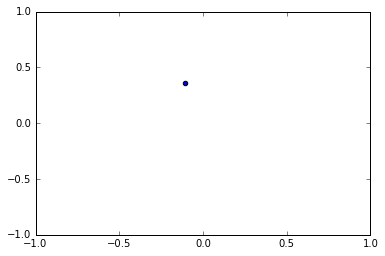

In [57]:
x,y = to_skyplot(EL,AZ)
axes = plt.gca()
axes.set_xlim([-1,1])
axes.set_ylim([-1,1])
plt.scatter(x,y)

In [66]:
import datetime
#PRN = All

Longitude_inGround = -73.1224429 
Latitude_inGround = 7.1388027
WeekSec = UTC2GPS(datetime.datetime.now()) #second of week
print WeekSec
list_PRN = []
AZIMUTH = []
ELEVATION = []
Times = []
Diffs = []
ownPRN = np.arange(0,32)
prueba = 1

navfile = 'navRINEX'
navHeader, navData = gpstk.readRinex3Nav(navfile)
bcestore = gpstk.GPSEphemerisStore()
 
for navDataObj in navData:
    ephem = navDataObj.toGPSEphemeris()
    #bcestore.addEphemeris(ephem)
    
    if 1 == 1: #ephem.HOWtime <= WeekSec: # and math.fabs(WeekSec-ephem.HOWtime) <= 21600.:  #21600 is 6 hours in seconds
        #print "SAT: ",ephem.satID," Time: ",ephem.HOWtime, " Diff: ", math.fabs(WeekSec-ephem.HOWtime)
        list_PRN.append(str(ephem.satID))
        Times.append(ephem.HOWtime)
        Diffs.append(math.fabs(WeekSec-ephem.HOWtime))
        POS = future_position(ephem,WeekSec,1937)
        AZ,EL = ECEFtoAzElev(POS,Longitude_inGround,Latitude_inGround)
        AZIMUTH.append(AZ)
        ELEVATION.append(EL)
        if prueba == 1:
            print ephem.satID
            prueba += 1
        
RES = pd.DataFrame({"SATID":list_PRN ,"Time": Times, "Diff":Diffs,"Elev": ELEVATION,"Azimuth": AZIMUTH,})
        
bcestore.SearchNear()
navData.close()

115230
GPS 1


In [68]:
RES.head()

,Azimuth,Diff,Elev,SATID,Time
0,36.181661,165570,47.628345,GPS 1,280800
1,337.713838,215970,45.005512,GPS 2,331200
2,177.966296,172770,50.578808,GPS 3,288000
3,122.462351,274290,61.380014,GPS 4,389520
4,166.195111,223200,56.916518,GPS 5,338430


In [67]:
RES.tail()

,Azimuth,Diff,Elev,SATID,Time
226,242.140150,311850,20.300536,GPS 7,427080
227,356.363148,312390,1.469682,GPS 8,427620
228,93.792841,312450,74.886592,GPS 15,427680
229,160.521615,314310,67.609189,GPS 13,429540
230,340.816264,315660,18.129045,GPS 10,430890


In [ ]:
for k in range (0,len(RES)):
    if 

In [ ]:
fig =plt.figure(figsize=(6,6))
axes = plt.gca()
axes.set_xlim([-1,1])
axes.set_ylim([-1,1])
plt.scatter(sx3,sy3,s=1, alpha=0.5, color = 'blue')
plt.scatter(sxo,syo,s=1, alpha=0.5, color = 'black')
plt.title('PRN Position')
plt.grid()

In [66]:
import datetime
#PRN = All

Longitude_inGround = -73.1224429 
Latitude_inGround = 7.1388027
WeekSec = UTC2GPS(datetime.datetime.now()) #second of week
print WeekSec
list_PRN = []
AZIMUTH = []
ELEVATION = []
Times = []
Diffs = []
ownPRN = np.arange(0,32)
prueba = 1

navfile = 'navRINEX'
navHeader, navData = gpstk.readRinex3Nav(navfile)
bcestore = gpstk.GPSEphemerisStore()
 
for navDataObj in navData:
    ephem = navDataObj.toGPSEphemeris()
    #bcestore.addEphemeris(ephem)
    
    if 1 == 1: #ephem.HOWtime <= WeekSec: # and math.fabs(WeekSec-ephem.HOWtime) <= 21600.:  #21600 is 6 hours in seconds
        #print "SAT: ",ephem.satID," Time: ",ephem.HOWtime, " Diff: ", math.fabs(WeekSec-ephem.HOWtime)
        list_PRN.append(str(ephem.satID))
        Times.append(ephem.HOWtime)
        Diffs.append(math.fabs(WeekSec-ephem.HOWtime))
        POS = future_position(ephem,WeekSec,1937)
        AZ,EL = ECEFtoAzElev(POS,Longitude_inGround,Latitude_inGround)
        AZIMUTH.append(AZ)
        ELEVATION.append(EL)
        if prueba == 1:
            print ephem.satID
            prueba += 1
        
RES = pd.DataFrame({"SATID":list_PRN ,"Time": Times, "Diff":Diffs,"Elev": ELEVATION,"Azimuth": AZIMUTH,})
        
bcestore.SearchNear()
navData.close()

115230
GPS 1
